### Calcualte shift values for all stars and explore the results

In [4]:
# imports
import astropy.io.fits 
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
import datetime 
import os
from astroquery.simbad import Simbad

In [25]:

# define constants and APF wavelenght scale (only used to determine order boundaries)
apf_wave = astropy.io.fits.open('apf_wav.fits')
c = 2.99 * 10**8 # m/s
solar_ref = astropy.io.fits.open('./APF_spectra/HD10700/ND.fits')[0].data #  tau ceti
solar_ref_wl = astropy.io.fits.open('./APF_spectra/HD10700/ND.fits')[1].data 


def calculate_shifts(star_name, path_unshifted, path_shifted, verbosity = 1, make_plots = False):
    hdu_U = astropy.io.fits.open(path_unshifted)
    hdu_S = astropy.io.fits.open(path_shifted)
    
    # define the flux an wavelenght values
    wl_unshifted = hdu_U[1].data
    wl_shifted = hdu_S[1].data
    unshifted = hdu_U[0].data
    shifted = hdu_S[0].data

    # create lists to hold shift values
    pix_shift_arr = []
    wl_shift_arr = []
    v_shift_arr = []
    max_xcorr_value_arr = []
    midpoints = []

    for order in np.arange(32,44):

        # find order boundaries
        apf_order = apf_wave[0].data[order]
        low_bound = apf_order[0]
        up_bound = apf_order[-1]

        # define data for this order
        idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) 
        idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
        idxs_order_solar = (solar_ref_wl > low_bound) * (solar_ref_wl < up_bound)
        flux_U = unshifted[idxs_order_unshifted]
        flux_S = shifted[idxs_order_shifted]
        flux_solar = solar_ref[idxs_order_solar]
        wl_U = wl_unshifted[idxs_order_unshifted]
        wl_S = wl_shifted[idxs_order_shifted]
        wl_solar = solar_ref_wl[idxs_order_solar]

        # calculate cross-correlation and calculate shifts 
        # shift each section so median is zero (otherwise the zero padding in cross correlation causes an issue)
        flux_S_centered = flux_S - np.median(flux_S)
        flux_U_centered = flux_U - np.median(flux_U)
        xcorr = np.correlate(flux_S_centered, flux_U_centered, mode='full')
        max_xcorr = np.where(xcorr == np.max(xcorr))[0]
        max_xcorr_value = np.max(xcorr)
        pixel_shift = len(wl_S) - max_xcorr 
        approx_delta_wl = np.mean(wl_U[1:] - wl_U[:-1]) # approximate becuase varies across spectrum
        wl_shift = pixel_shift*approx_delta_wl # approximate becuase uses assumption of constant wl per pixel
        delta_v = c * wl_shift / np.mean(wl_U) / 1000 # km/s
        midpoints += [np.mean(wl_U)]
        
        if (make_plots | (float(delta_v) < 2)) and order == 34:    
            # plot shifted and unshifted spectra for reference
            plt.figure(figsize = [12,8])
            plt.subplot(211)
            plt.plot(wl_U, flux_U, '.-', label = 'unshifted', ms = 1)
            plt.plot(wl_S, flux_S, '.-', label = 'shifted', ms = 1)
            #plt.plot(wl_solar, flux_solar, '.-', label = 'solar reference', ms = 1)
            plt.xlabel('Wavelength [A]')
            plt.ylabel('Intensity')
            plt.title(star_name + ' Order: ' + str(order))
            #plt.xlim([5260,5280])
            plt.legend()

            # plot cross-correlation results
            plt.subplot(212)
            pix_lags = np.hstack([np.flip(np.arange(0,len(wl_U),1)*(-1))[1:], np.array([0]), np.arange(0,len(wl_U),1)[:-1]])   
            v_lags = pix_lags * approx_delta_wl * c / np.mean(wl_U) / 1000 # approximation becuase assumes constant wl per pixel and uses avg wl value
            xlim_l = np.where(v_lags < -200)[0][-1]
            xlim_u = np.where(v_lags > 200)[0][0]
            plt.plot(v_lags[xlim_l:xlim_u], xcorr[xlim_l:xlim_u])
            plt.xlabel('Velocity shift [km/s]')
            plt.ylabel('Cross-correlation')

        if verbosity > 0:
            print('Order ' + str(order))
            print('    Shift in pixels: ' + str(pixel_shift[0]))
            print('    Shift in wl: ' + str(wl_shift[0]))
            print('    Shift in v: ' + str(delta_v[0]))

        pix_shift_arr += [pixel_shift]
        wl_shift_arr += [wl_shift]
        v_shift_arr += [delta_v]
        max_xcorr_value_arr += [max_xcorr_value]

    pix_shift_arr = np.array(pix_shift_arr)
    wl_shift_arr = np.array(wl_shift_arr)
    v_shift_arr = np.array(v_shift_arr)[:,0]
    max_xcorr_value_arr = np.array(max_xcorr_value_arr)
    
    # interpolate to get a wavelenght shift value for each pixel
    #full_wl_shift_arr = np.interp(wl_shifted, midpoints, wl_shift_arr.reshape(len(wl_shift_arr),)) # this doesn't work wll near the ends
    
    # Find the median shift value
    med_v_shift = np.median(v_shift_arr)
    make_shift_plots = False
    if make_shift_plots:
        plt.figure()
        plt.plot(np.linspace(0,len(v_shift_arr)-1, len(v_shift_arr)), v_shift_arr, '.-')
        plt.xlabel('Order')
        plt.ylabel('Velocity shift value')
        plt.text(2,4,'Median velocity shift value: ' + str(np.round(med_v_shift,3)))
    if verbosity > 0:
        print('Median velocity shift value: ' + str(np.round(med_v_shift,3)))
        
    # get an array of wl shift values for each pixel
    wl_shift_full = wl_shifted * med_v_shift / c * 1000
        
    return wl_shift_arr, midpoints, wl_shifted, wl_shift_full, wl_unshifted, shifted, unshifted, med_v_shift, max_xcorr_value_arr

In [ ]:
dt = datetime.datetime.now()
print('Timestamp: ' +  str(dt.strftime("%d") + dt.strftime("%b") + dt.strftime("%Y") + '-' + dt.strftime("%X")))

import matplotlib.ticker as plticker
#plt.plot(midpoints[:-2], wl_shift_arr[:-2], 'o')
#plt.plot(wl_shifted, wl_shift_full, '.', ms = 0.1)
# check that this gives the right shifts in wl

star_list = os.listdir('/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf')
all_targets_v_shifts = np.zeros(len(star_list)) * np.nan
mean_max_xcorr =np.zeros(len(star_list)) * np.nan
names = []

i=0
for star in star_list:  
    name = star.split('_')[0]
    names += [name]
    NDRU_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRU_all_apf/' + name + '_NDRU.fits'
    NDRS_path = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf/' + name + '_NDRS.fits'
    wl_shift_arr, midpoints, wl_shifted, wl_shift_full, wl_unshifted, shifted, unshifted, med_v_shift, max_xcorr_value_arr = calculate_shifts(name, NDRU_path,
                                                                                                                         NDRS_path, 
                                                                                                                         verbosity = 0,
                                                                                                                         make_plots = False)

    all_targets_v_shifts[i] = med_v_shift
    mean_max_xcorr[i] = np.nanmean(max_xcorr_value_arr)
    i += 1
    #if i%100 == 0:
    #    print(i)
       
    #plt.figure(figsize = [15,5])
    #plt.plot(wl_shifted, shifted, label = 'shifted')
    #plt.plot(wl_unshifted, unshifted, label = 'unshifted')
    #plt.xlim([5550,5560])
    #plt.legend()
    #plt.xlabel('Wavelenght [A]')
    #plt.ylabel('Intensituy')
    
    print(name + ': ' + str(med_v_shift) + ' km/s')
    print()
    '''
    if med_v_shift < 2:

        for order in np.arange(34,35,1):
                # find order boundaries
                apf_order = apf_wave[0].data[order]
                low_bound = apf_order[1200] # 1200 just to zoom in on plots to see shift better
                up_bound = apf_order[-1200]

                # define data for this order
                idxs_order_shifted = (wl_shifted > low_bound) * (wl_shifted < up_bound) # order 40 for example
                idxs_order_unshifted = (wl_unshifted > low_bound) * (wl_unshifted < up_bound)
                flux_U = unshifted[idxs_order_unshifted]
                flux_S = shifted[idxs_order_shifted]
                wl_U = wl_unshifted[idxs_order_unshifted]
                wl_S = wl_shifted[idxs_order_shifted]
                shifts = wl_shift_full[idxs_order_shifted]

                fig, ax  = plt.subplots(figsize = [15,5])
                ax.plot(wl_U, flux_U, color = 'C0',  label = 'unshifted')        
                ax.plot(wl_S, flux_S, color = 'C1', label = 'shifted')
                ax.set_xlabel('Wavelength [A]')
                ax.set_ylabel('Intensity')
                ax.xaxis.set_major_locator(plticker.MultipleLocator(base=2))
                ax.xaxis.set_minor_locator(plticker.MultipleLocator(1))
                ax.legend()

                #xticks = ax.get_xticks() # get the xtick values for the wavelenght scale
                #reverse_shifted_xticks = xticks + np.round(xticks * med_v_shift / c * 1000, 2)

                ax2 = ax.twiny()

                ax2.plot(wl_S + wl_S * med_v_shift / c * 1000, flux_S, color = 'C3' , ls = None)
                ax2.xaxis.set_major_locator(plticker.MultipleLocator(base=2))
                ax2.xaxis.set_minor_locator(plticker.MultipleLocator(1))


                ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
                ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
                ax2.spines['bottom'].set_position(('outward', 36))
                ax2.set_xlabel('Unshifted wavelenght corresponding to shifted wavelength [A]')
                plt.title(name + ', order 34')
            '''
    
data = {'Star_name': names,
        'Velocity_shift [km/s]': all_targets_v_shifts,
        'X-corr_peak': mean_max_xcorr}

df = pd.DataFrame(data)
df.to_csv('Velocity_shift_all_targets_updated.csv')

Text(0.5, 0, 'Velocity shift (km/s)')

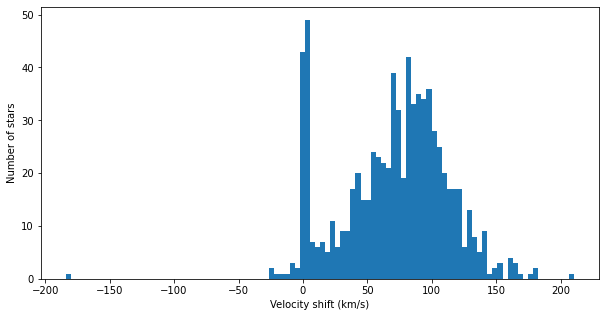

In [87]:
plt.figure(figsize = [10,5])
nums, bin_edges =  np.histogram(all_targets_v_shifts, bins = 100)
#print(nums)
#print(bin_edges)
plt.hist(all_targets_v_shifts, bins = 100)
plt.ylabel('Number of stars')
plt.xlabel('Velocity shift (km/s)')
#plt.xlim([-1,10])

### What cuases the pileup at ~ 1km/s?

In [155]:
slow_stars = [star_list[i].split('_')[0] for i in list(np.where((all_targets_v_shifts < 2) * (all_targets_v_shifts > -2 ))[0])]
len(slow_stars)

46

In [22]:
def get_names(sim_name):
    # get Gaia and 2MASS names 
    result_table = Simbad.query_objectids(sim_name)
    names = result_table.to_pandas()['ID'].to_list()
    gaia_name = [name.decode('utf-8').split(' ')[-1] for name in names if name.decode('utf-8').startswith('Gaia DR2')]
    two_MASS_name = [name.decode('utf-8').split('J')[-1] for name in names if name.decode('utf-8').startswith('2MASS')]
    (gaia_source_id,) = gaia_name
    (id_2MASS,) = two_MASS_name
    return gaia_source_id, id_2MASS

In [23]:
v_shifts_file = pd.read_csv('Velocity_shift_all_targets_updated.csv')
SM_results = pd.read_csv('SM_stellar_properties/all_apf/11Jan2022/specmatch_results_11Jan2022.csv')
gaia_values = pd.read_csv('/mnt_home/azuckerman/BL_APF_DAP/gaia_values.csv')

star_list = v_shifts_file['Star name']
all_targets_v_shifts = v_shifts_file['Velocity_shift [km/s]']
slow_stars = [star_list[i].split('_')[0] for i in list(np.where(all_targets_v_shifts < 2)[0])]

SNR_arr = np.zeros(len(star_list)) * np.nan
Teff_arr = np.zeros(len(star_list)) * np.nan
R_arr = np.zeros(len(star_list)) * np.nan
gaia_Teff_arr = np.zeros(len(star_list)) * np.nan
gaia_R_arr = np.zeros(len(star_list)) * np.nan
delta_T_arr = np.zeros(len(star_list)) * np.nan
delta_R_arr = np.zeros(len(star_list)) * np.nan
chi_sq_arr = np.zeros(len(star_list)) * np.nan
for i in range(len(star_list)):
    name = star_list[i].split('_')[0]
    results_row = SM_results[SM_results['Simbad_resolvable_name'] == name]
    SNR_arr[i] = results_row['SNR']
    Teff_arr[i] = results_row['iso_Teff']
    R_arr[i] = results_row['iso_radius']
    if Teff_arr[i] == 0: Teff_arr[i] = np.nan
    if R_arr[i] == 0: R_arr[i] = np.nan
    chi_sq_arr[i] = results_row['best_mean_chi_squared']
    
    # get Gaia data to compare
    try:
        gaia_source_id, id_2MASS = get_names(name)
        gaia_row = gaia_values.loc[gaia_values['source_id'] == int(gaia_source_id)] # star has been run so should be here
        gaia_row = gaia_row.median(axis = 0, skipna = True)
        gaia_R_arr[i] = gaia_row['radius_val']
        gaia_Teff_arr[i] = gaia_row['teff_val']
        delta_T_arr[i] = Teff_arr[i] - gaia_Teff_arr[i]
        delta_R_arr[i] = R_arr[i] - gaia_R_arr[i]
    except ValueError:
        gaia_R_arr[i] = np.nan
        gaia_Teff_arr[i] = np.nan
        delta_T_arr[i] = np.nan
        delta_R_arr[i] = np.nan
            #Teff_arr[i] = results_row['iso_Teff']
    

In [ ]:
star_list[all_targets_v_shifts < 2]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


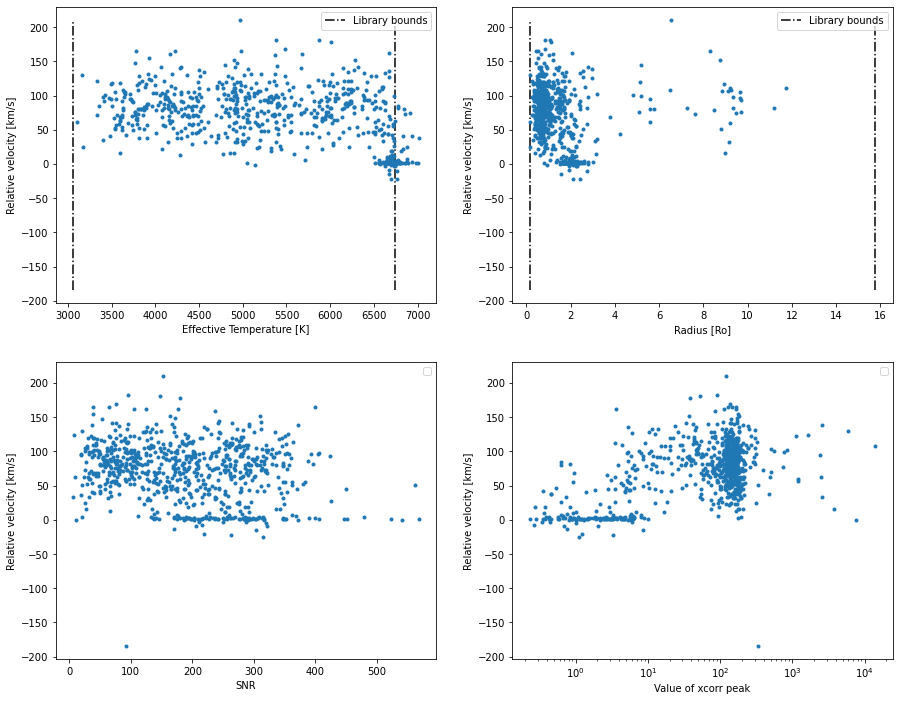

In [27]:

plt.figure(figsize = [15,12])
plt.subplot(221)
plt.plot(Teff_arr, all_targets_v_shifts, '.')
plt.vlines([3056, 6738], ymin = np.nanmin(all_targets_v_shifts), ymax = np.nanmax(all_targets_v_shifts), ls = '-.',  label = 'Library bounds')
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(222)
plt.plot(R_arr, all_targets_v_shifts, '.')
plt.vlines([0.168, 15.781], ymin = np.nanmin(all_targets_v_shifts), ymax = np.nanmax(all_targets_v_shifts), ls = '-.',  label = 'Library bounds')
plt.xlabel('Radius [Ro]')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(223)
plt.plot(SNR_arr, all_targets_v_shifts, '.')
plt.xlabel('SNR')
plt.ylabel('Relative velocity [km/s]')
plt.legend()

plt.subplot(224)
plt.plot(mean_max_xcorr, all_targets_v_shifts, '.')
plt.xlabel('Value of xcorr peak')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()

773

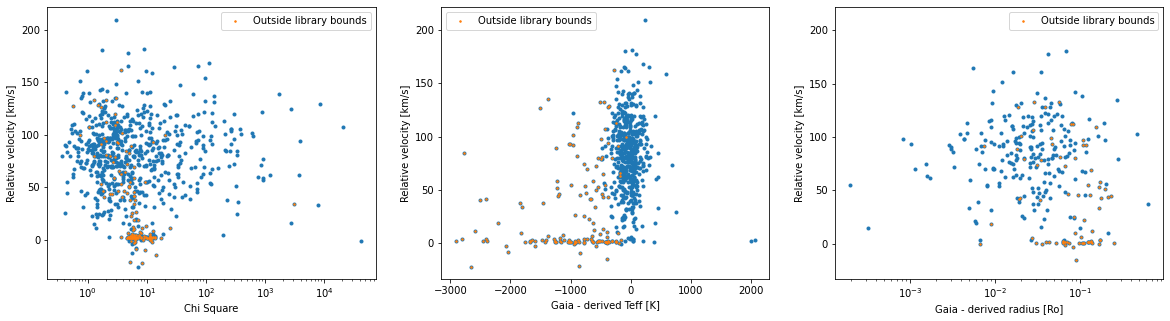

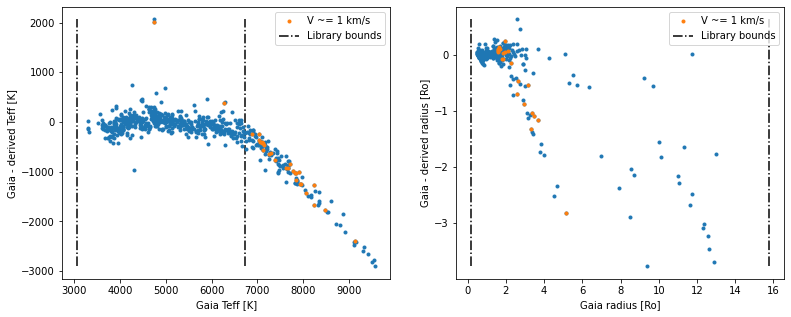

In [32]:
# do the stars that are given a ~1 km/s velocity shift by SM produce poor stellar property results 
# (indicating they are shifted improprly)

slow_star_mask = (all_targets_v_shifts < 2) * (all_targets_v_shifts > 0)
outside_gaia_T_bounds = (gaia_Teff_arr > 6738) | (gaia_Teff_arr < 3056)
outside_gaia_R_bounds = (gaia_R_arr > 15.781) | (gaia_R_arr < 0.168)

plt.figure(figsize = [20,5])
plt.subplot(131)
plt.plot(chi_sq_arr, all_targets_v_shifts, '.')
plt.plot(chi_sq_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Chi Square')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()

plt.subplot(132)
plt.plot(delta_T_arr, all_targets_v_shifts, '.')
plt.plot(delta_T_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Gaia - derived Teff [K]')
plt.ylabel('Relative velocity [km/s]')
#plt.xscale('log')
plt.legend()

plt.subplot(133)
plt.plot(delta_R_arr, all_targets_v_shifts, '.')
plt.plot(delta_R_arr[outside_gaia_T_bounds | outside_gaia_R_bounds], all_targets_v_shifts[outside_gaia_T_bounds | outside_gaia_R_bounds], '.', ms = 3, label = 'Outside library bounds')
plt.xlabel('Gaia - derived radius [Ro]')
plt.ylabel('Relative velocity [km/s]')
plt.xscale('log')
plt.legend()


plt.figure(figsize = [20,5])
plt.subplot(131)
plt.plot(gaia_Teff_arr, delta_T_arr, '.')
plt.plot(gaia_Teff_arr[slow_star_mask], delta_T_arr[slow_star_mask], '.', label = 'V ~= 1 km/s')
plt.vlines([3056, 6738], ymin = np.nanmin(delta_T_arr), ymax = np.nanmax(delta_T_arr), ls = '-.',  label = 'Library bounds')
plt.xlabel('Gaia Teff [K]')
plt.ylabel('Gaia - derived Teff [K]')
plt.legend()

plt.subplot(132)
plt.plot(gaia_R_arr, delta_R_arr, '.')
plt.plot(gaia_R_arr[slow_star_mask], delta_R_arr[slow_star_mask], '.', label = 'V ~= 1 km/s')
plt.vlines([0.168, 15.781], ymin = np.nanmin(delta_R_arr), ymax = np.nanmax(delta_R_arr), ls = '-.',  label = 'Library bounds')
plt.xlabel('Gaia radius [Ro]')
plt.ylabel('Gaia - derived radius [Ro]')
plt.legend()

In [125]:
delta_T

-48.24300000000039